# Part2. 머신러닝, 딥러닝
### 시계열 모델을 통한 농수산물 소매가격 예측
1. 데이터 탐색
2. ARMA
3. ARIMA
4. SARIMA
6. LSTM
7. 회귀모델

In [1]:
## 필요 라이브러리
# 데이터 전처리 라이브러리
import numpy as np
import pandas as pd

# 시각화 라이브러리
import matplotlib.pylab as plt
plt.rcParams['font.family'] = ('AppleGothic', 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import seaborn as sns


# 기타
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 탐색

In [2]:
# 2017~2021년 데이터 불러오기
df = pd.read_csv('data/2017_2021_data.csv', usecols=[1,2,3], encoding='euc-kr')
df['날짜'] = pd.to_datetime(df['날짜'], infer_datetime_format = True)
df = df.set_index(['날짜'])
df.head()

,고구마가격,오이가격
날짜,,
2017-01-02,4442,8907.0
2017-01-03,4463,9011.0
2017-01-04,4461,9101.0
2017-01-05,4430,10296.0
2017-01-06,4423,10374.0


In [3]:
df.shape

(1226, 2)

## 1.1 2017년 ~ 2021년 농수산물 소매가격 변화

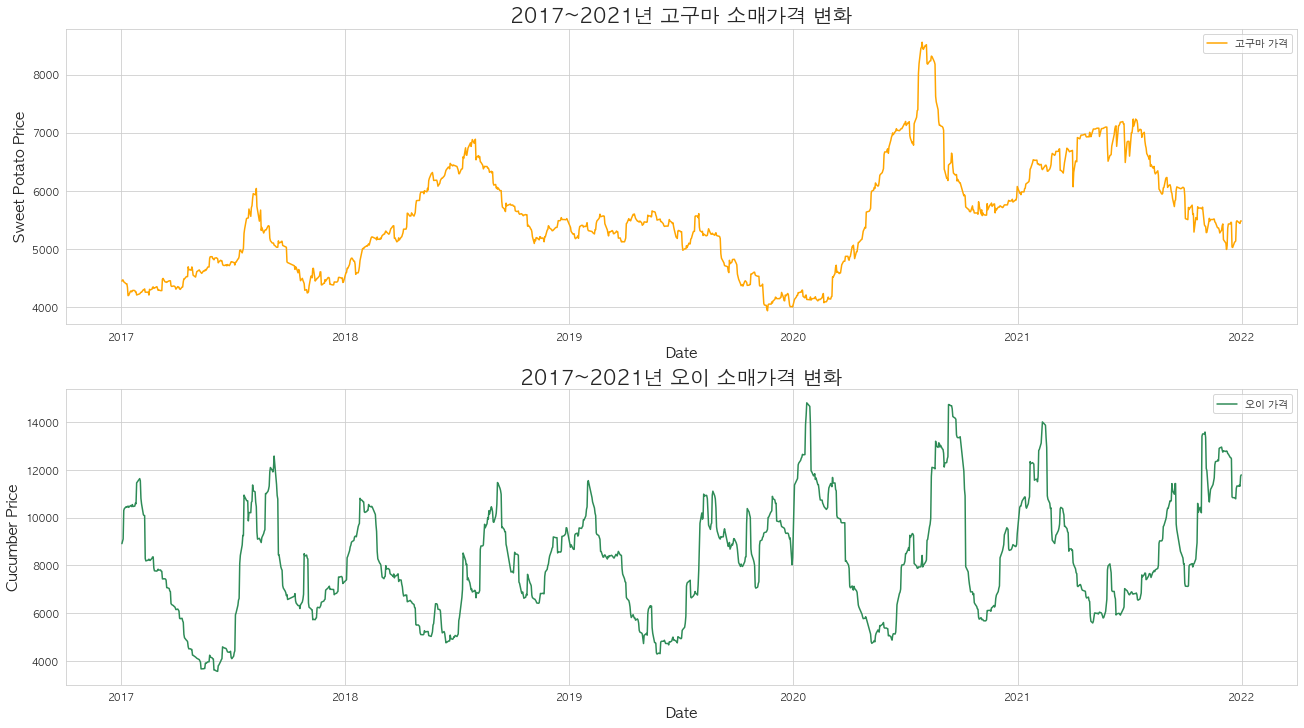

In [25]:
## 5년간 소매가격 변화 시각화
fig = plt.figure(figsize=(18,10), constrained_layout=True)

# 고구마
ax1 = fig.add_subplot(211)
ax1.set_title('2017~2021년 고구마 소매가격 변화', fontsize=20)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Sweet Potato Price', fontsize=15)
ax1.plot(df['고구마가격'], label='고구마 가격', color='orange')
ax1.legend()

# 오이
ax2 = fig.add_subplot(212)
ax2.set_title('2017~2021년 오이 소매가격 변화', fontsize=20)
ax2.set_xlabel('Date', fontsize=15)
ax2.set_ylabel('Cucumber Price', fontsize=15)
ax2.plot(df['오이가격'], label='오이 가격', color='seagreen')
ax2.legend()

plt.savefig('data/data01.png')
plt.show()

## 1.2 이상치 탐색

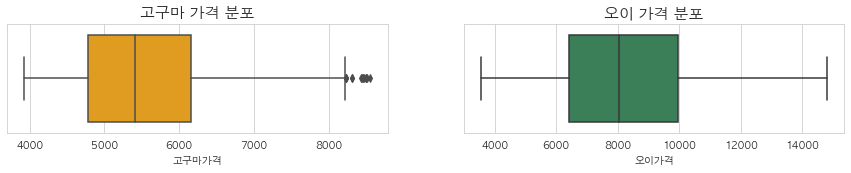

In [27]:
## 가격 데이터의 이상치 확인
fig = plt.figure(figsize=(15, 2))

# 고구마
ax1 = fig.add_subplot(121)
ax1.set_title('고구마 가격 분포', fontsize=15)
sns.boxplot(df['고구마가격'], ax=ax1, color='orange')

# 오이
ax2 = fig.add_subplot(122)
ax2 .set_title('오이 가격 분포', fontsize=15)
sns.boxplot(df['오이가격'], ax=ax2, color='seagreen')

plt.savefig('data/data02.png')
plt.show()

## 1.3 데이터 추세 시각화

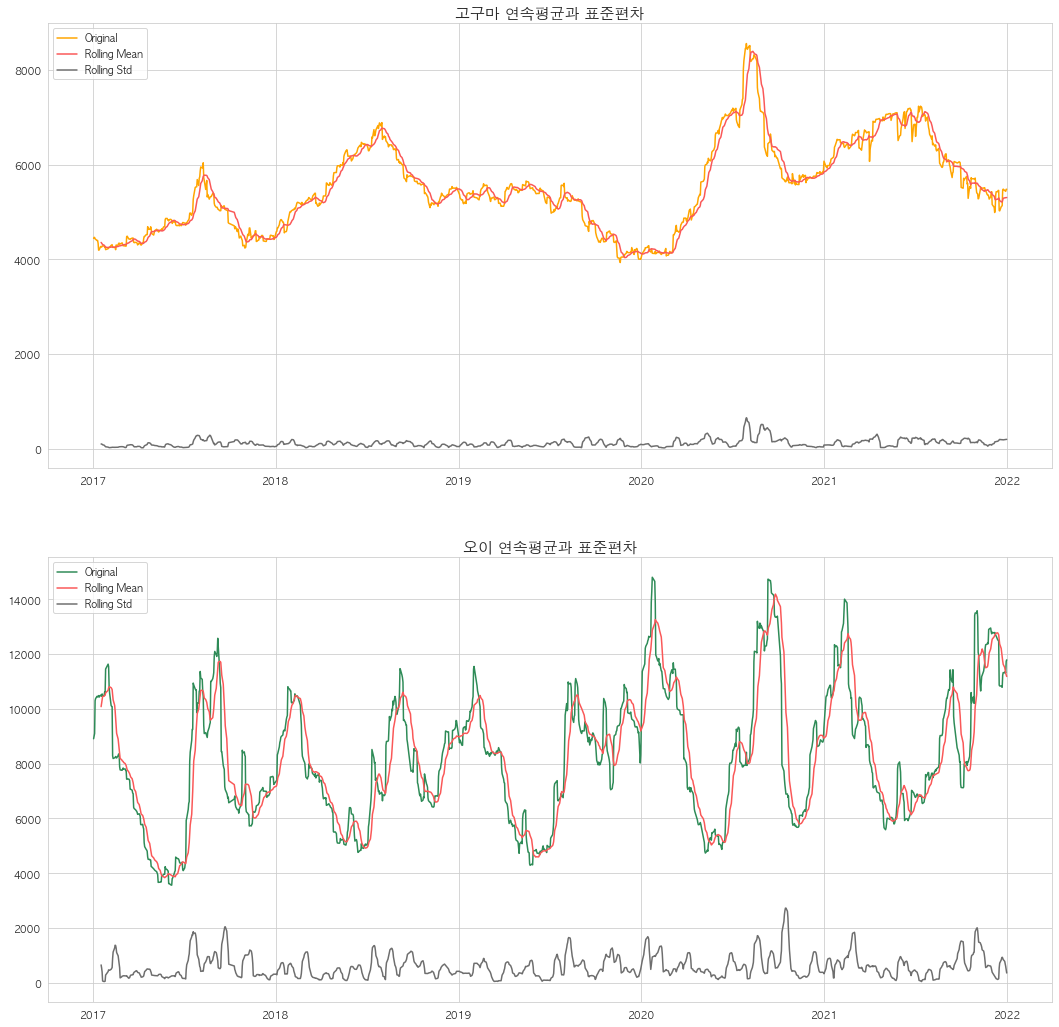

In [6]:
## Rolling Statistics - 데이터 추세 확인 시각화
# rolling average : 연속 평균
# window size 12 denotes 12 months, giving rolling mean at yearly level

fig = plt.figure(figsize=(18,18))

# 고구마
df['고구마_rolling_avg'] = df['고구마가격'].rolling(window=12).mean()
df['고구마_rolling_std'] = df['고구마가격'].rolling(window=12).std()

ax1 = fig.add_subplot(211)
ax1.plot(df['고구마가격'], color='orange', label='Original')
ax1.plot(df['고구마_rolling_avg'], color='#FA5858', label='Rolling Mean')
ax1.plot(df['고구마_rolling_std'], color='#6E6E6E', label='Rolling Std')
ax1.legend(loc='upper left')
ax1.set_title('고구마 연속평균과 표준편차', fontsize=15)

# 오이
df['오이_rolling_avg'] = df['오이가격'].rolling(window=12).mean()
df['오이_rolling_std'] = df['오이가격'].rolling(window=12).std()

ax2 = fig.add_subplot(212)
ax2.plot(df['오이가격'], color='seagreen', label='Original')
ax2.plot(df['오이_rolling_avg'], color='#FA5858', label='Rolling Mean')
ax2.plot(df['오이_rolling_std'], color='#6E6E6E', label='Rolling Std')
ax2.legend(loc='best')
ax2.set_title('오이 연속평균과 표준편차', fontsize=15)

plt.savefig('data/data03.png')
plt.show(block=False)

## 1.4 Stationarity
##### 1.4.1 Stationarity 검정

- Augemented Dickey_Fuller Test
    - from statsmodels.tsa.stattools import adfuller
    - 귀무가설: unit root 존재 = non-stationarity
    - 대립가설: unit root 없음 = stationarity
    - p-value가 0.05보다 작으면 시계열이 stationary

In [7]:
## Stationarity Test - ADF Test
from statsmodels.tsa.stattools import adfuller

# 고구마
adfuller_result = adfuller((df['고구마가격']))
print(f'고구마 ADF Statistic: {adfuller_result[0]}')
print(f'고구마 p-value: {adfuller_result[1]}')
print()

# 오이
adfuller_result = adfuller((df['오이가격']))
print(f'오이 ADF Statistic: {adfuller_result[0]}')
print(f'오이 p-value: {adfuller_result[1]}')

고구마 ADF Statistic: -2.195827294289684
고구마 p-value: 0.2077633926590075

오이 ADF Statistic: -4.260401717058947
오이 p-value: 0.0005198280620778618


- 고구마 데이터의 p-value는 유의수준보다 크므로 귀무가설 채택. 즉, non-stationary 데이터임 -> 차분 필요
- 오이 데이터의 p-value는 유의수준보다 작아 귀무가설 기각. 즉, stationary 데이터임

##### 1.4.2 시각화를 통한 stationarity 확인

- ACF(Auto-Correlation Fuction): 자기상관함수
    - 시리즈의 현재 값이 과거 값과 얼마나 잘 연관되어 있는지
    - trend가 있는 시계열의 ACF는 양의 값
    - seasonality가 있을 때는 값이 더 크게 나옴

- PACF(Partial Auto-Correlation Function): 편자기함수
    - 잔차와 다음 지연 값의 상관 관계

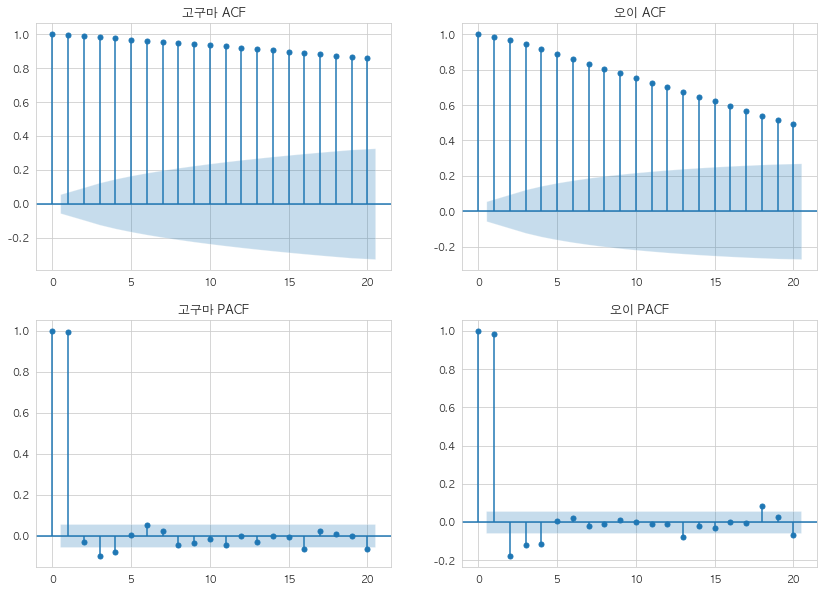

In [8]:
## ACF, PACF 시각화
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(14,10))

# 고구마
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(df['고구마가격'],lags=20,ax=ax1, title='고구마 ACF')

ax3 = fig.add_subplot(223)
fig = sm.graphics.tsa.plot_pacf(df['고구마가격'],lags=20,ax=ax3, title='고구마 PACF')

# 오이
ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_acf(df['오이가격'],lags=20,ax=ax2, title='오이 ACF')

ax4 = fig.add_subplot(224)
fig = sm.graphics.tsa.plot_pacf(df['오이가격'],lags=20,ax=ax4, title='오이 PACF')

plt.savefig('data/data04.png')
plt.show()

- ACF 그래프 해석:
    - 시차 1에서부터 지수적으로 감소(AR 특성)
    - 데이터에 자기회귀항이 있음. 자기 회귀항의 차수를 확인하기 위해 PACF 확인 필요
- PACF 그래프 해석:
    - 값이 1인 경우 자기상관성 존재함
    - 2차에서 값이 급격히 줄어들며, 음의 상관성이 같이 나타남(MA 특성)
- 결론:
    - ACF와 PACF 그래프의 형태를 통해 고구마 가격의 시계열이 ARMA 모형에 가깝고, non-stationary 데이터이므로 ARIMA 모형이 적합할 것
    - ACF와 PACF 그래프의 형태를 통해 오이가격의 시계열이 ARMA 모형에 적합할 것

# 2. ARMA

In [9]:
from scipy.stats import norm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA

### 2.1 ARMA 모델 차수 결정
##### 2.1.1 ESACF를 이용한 차수 결정
- ESACF 값이 통계적으로 0에 가까우면 'O', 아니면 'X'로 표기
- O가 역삼각형 모양으로 나오는 꼭짓점의 위치를 적절한 차수로 가정
- stats.norm: 가우시안 정규분포 객체 생성
    - ppf: Percent point function. cdf(누적분포확률)의 반대

In [10]:
## ESACF를 이용한 ARMA 차수 결정

# ESACF 테이블을 그리는 함수 정의
def esacf(data, ar_max=7, ma_max = 13, alpha=0.05, symbol=True):
    sig = norm.ppf(1-alpha/2)

    # 배열을 한 시점 이전으로 이동시키기 -> 데이터프레임 앞에 nan값 추가 후 배열 변환
    def lag_function(data, lag=1):
        res = [np.nan]*lag + list(data[:-lag])
        res = np.array(res)
        return res

    # OLS를 이용하여 자기회귀모형 적합 후 추정된 계수 출력
    def ar_ols(data, ar_order):
        depedent_data = np.array(data[ar_order:])
        X = np.empty((0,ar_order))
        for i in range(ar_order,len(data)):
            temp_row = data[i-ar_order:i][::-1]
            X = np.vstack([X, temp_row])

        model = sm.OLS(depedent_data,X)
        results = model.fit()
        return results.params

    # 최소 제곱 회귀를 반복 적용하여 AR계수 추정치를 행렬로 표기
    def reupm(mat, ncol):
        k = ncol-1
        nrow = mat.shape[0]

        for i in range(k):
            i1 = i+1
            work = lag_function(mat[:,i])
            work[0] = -1
            temp = mat[:,i1] - (mat[i1,i1]/mat[i,i])*work
            temp[i1] = 0
            if i ==0:
                mat2 = np.expand_dims(temp, axis=1)
            else:
                mat2 = np.column_stack((mat2, temp))
        return mat2

    ar_max += 1
    ma_max += 1
    nar = ar_max-1
    nma = ma_max
    ncov = nar + nma + 2
    nrow = nar + nma + 1
    ncol = nrow - 1

    # ESACF 테이블의 컬럼 출력
    def ceascf(m, cov1, nar, ncol, count, ncov, z, zm):
        result = [0]*(nar+1)
        result[0] = cov1[ncov+count]
        for i in range(nar):
            temp = np.column_stack((z[i+1:], zm[i+1:,:i+1])).dot([1]+list(-mat2[:i+1, i]))
            result[i+1] = acf(temp, nlags=count+1, fft=False)[count+1]
        return result

    z = data-np.mean(data)

    for i in range(nar):
        if i == 0:
            zm = np.expand_dims(lag_function(z,i+1), axis=1)
        else:
            zm = np.column_stack((zm,lag_function(z,i+1)))

    cov1 = acf(z, nlags=ncov, fft=False)
    cov1 = np.array(list(cov1[1:][::-1]) + list(cov1))
    ncov += 1
    mat = np.zeros((nrow,ncol))
    for i in range(ncol):
        mat[:i+1,i] = ar_ols(z, ar_order=i+1)

    for i in range(nma):
        mat2 = reupm(mat, ncol)
        ncol = ncol - 1
        if i == 0:
            eacfm = np.expand_dims(ceascf(mat2, cov1, nar, ncol, i, ncov, z, zm),axis=1)
        else:
            eacfm = np.column_stack((eacfm,ceascf(mat2, cov1, nar, ncol, i, ncov, z, zm)))
        mat = mat2

    if symbol:
        work = len(z) - np.array(range(1, nar+2))+1
        for j in range(nma):
            work = work - 1
            temp = np.abs(eacfm[:,j]) > sig/np.sqrt(work)
            temp = np.array(['X' if t else 'O' for t in temp])
            if j == 0:
                symbol = np.expand_dims(temp, axis=1)
            else:
                symbol = np.column_stack((symbol, temp))
        return pd.DataFrame(symbol)
    else:
        return pd.DataFrame(eacfm)

In [11]:
## ESACF 차수 탐색
# 고구마
sp = df['고구마가격'].values
esacf(sp, ar_max=5, ma_max = 8, alpha=0.01, symbol=True)

,0,1,2,3,4,5,6,7,8
0,X,X,X,X,X,X,X,X,X
1,O,X,X,O,O,O,O,O,O
2,X,O,O,O,O,O,O,O,O
3,X,X,O,O,O,O,O,O,O
4,O,X,X,O,O,O,O,O,O
5,X,X,X,O,O,O,O,O,O


- 고구마 ESACF 분석:
    - 행 = AR차수, 열 = MA차수
    - O이 삼각형으로 분포되는 꼭짓점인 ARMA(2,1)이 적절한 차수

In [12]:
## ESACF 차수 탐색
# 오이
ccb = df['오이가격'].values
esacf(ccb, ar_max=5, ma_max = 8, alpha=0.01, symbol=True)

,0,1,2,3,4,5,6,7,8
0,X,X,X,X,X,X,X,X,X
1,X,X,X,O,O,O,O,O,O
2,X,O,X,O,O,O,O,O,O
3,X,O,X,O,X,O,O,O,O
4,O,X,X,O,O,O,O,O,O
5,X,X,X,X,O,O,O,O,O


- 오이 ESACF 분석:
    - 행 = AR차수, 열 = MA차수
    - O이 삼각형으로 분포되는 꼭짓점인 ARMA(1,3)이 적절한 차수

##### 2.1.2 AIC를 이용한 차수 결정

/Users/youngrong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


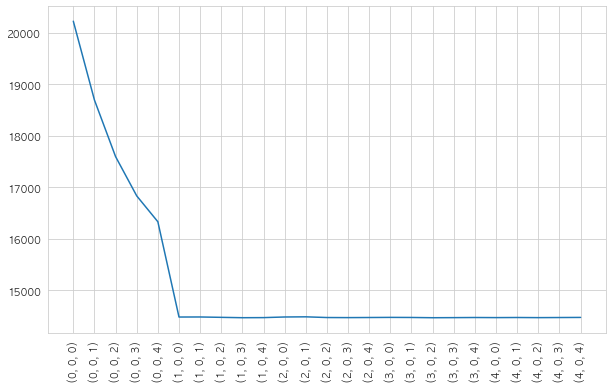

Order : (3, 0, 2), AIC : 14469.006018752125


In [13]:
## AIC를 이용한 차수 구하기 - 4차를 최대로 최적의 조합 찾기
# 고구마
ar_max = 4
ma_max = 4
aic_val = []
order_list = []

for ar in range(ar_max+1): #차수를 증가시키면서 모델에 fit하여 순서와 aic 값 저장
    for ma in range(ma_max+1):
        order = (ar, 0, ma)
        order_list.append(str(order))
        model = ARIMA(sp, order=order).fit()
        aic_val.append(model.aic)

# 시각화
fig = plt.figure(figsize=(10,6))
plt.plot(range(len(aic_val)), aic_val)
plt.xticks(range(len(aic_val)), order_list, rotation=90)

plt.savefig('data/arma01.png')
plt.show()

# AIC 값이 가장 작은 조합 찾기
order_aic = dict(zip(order_list, aic_val))
final_order, final_aic = sorted(order_aic.items(), key=lambda x:x[1])[0]
print(f'Order : {final_order}, AIC : {final_aic}')

/Users/youngrong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/youngrong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


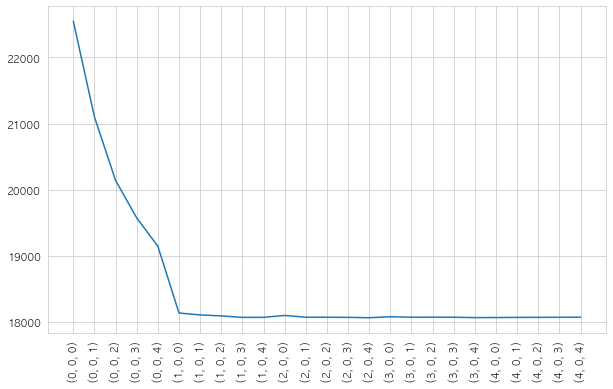

Order : (2, 0, 4), AIC : 18065.852858407117


In [14]:
## AIC를 이용한 차수 구하기
# 오이
ar_max = 4
ma_max = 4
aic_val = []
order_list = []
for ar in range(ar_max+1):
    for ma in range(ma_max+1):
        order = (ar, 0, ma)
        order_list.append(str(order))
        model = ARIMA(ccb, order=order).fit()
        aic_val.append(model.aic)

fig = plt.figure(figsize=(10,6))
plt.plot(range(len(aic_val)), aic_val)
plt.xticks(range(len(aic_val)), order_list, rotation=90)

plt.savefig('data/arma02.png')
plt.show()

# AIC 값이 가장 작은 조합 찾기
order_aic = dict(zip(order_list, aic_val))
final_order, final_aic = sorted(order_aic.items(), key=lambda x:x[1])[0]
print(f'Order : {final_order}, AIC : {final_aic}')

## 2.2 모델 생성
- 고구마
    - ESACF: (2, 1)
    - AIC: (3, 2)
    - 차수 조합이 더 작은 모델로 결정 (2, 1)
- 오이
    - ESACF: (1, 3)
    - AIC: (2, 4)
    - 차수 조합이 더 작은 모델로 결정 (1, 3)

In [15]:
## 모델 생성
# 고구마
final_model_sp = ARIMA(sp, order=(2,0,1)).fit()
final_model_sp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1226
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -7238.237
Date:                Tue, 16 Aug 2022   AIC                          14486.473
Time:                        00:27:14   BIC                          14512.031
Sample:                             0   HQIC                         14496.090
                               - 1226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5517.5306    464.027     11.891      0.000    4608.054    6427.008
ar.L1          0.1190      1.437      0.083      0.934      -2.697       2.935
ar.L2          0.8720      1.431      0.610      0.542      -1.932       3.676
ma.L1          0.8743      1.447      0.604      0.546      -1.962       3.710
sigma2      7834.1768    126.796     61.786      0.000    7585.661    8082.692
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):              6902.05
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               3.18   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
## 모델 생성
# 오이
final_model_ccb = ARIMA(ccb, order=(1,0,3)).fit()
final_model_ccb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1226
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -9029.488
Date:                Tue, 16 Aug 2022   AIC                          18070.975
Time:                        00:27:14   BIC                          18101.645
Sample:                             0   HQIC                         18082.516
                               - 1226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8235.5334    740.490     11.122      0.000    6784.200    9686.867
ar.L1          0.9742      0.007    132.883      0.000       0.960       0.989
ma.L1          0.1470      0.039      3.808      0.000       0.071       0.223
ma.L2          0.1400      0.029      4.825      0.000       0.083       0.197
ma.L3          0.1407      0.033      4.228      0.000       0.075       0.206
sigma2      1.461e+05   2545.660     57.396      0.000    1.41e+05    1.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             12740.47
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 2.3 모델 예측

In [17]:
# 성능 평가를 위한 2022년 actual 데이터 불러오기
df_2022 = pd.read_csv('data/2017_2022_data.csv', usecols=[1,2,3], encoding='euc-kr')
df_2022['날짜'] = pd.to_datetime(df_2022['날짜'], infer_datetime_format = True)
df_2022 = df_2022.set_index(['날짜'])
df_2022_sp = df_2022['고구마가격'].values
df_2022_ccb = df_2022['오이가격'].values

In [18]:
# 2017~2022.08 데이터 개수 확인
df_2022_sp.shape,df_2022_sp.shape

((1368,), (1368,))

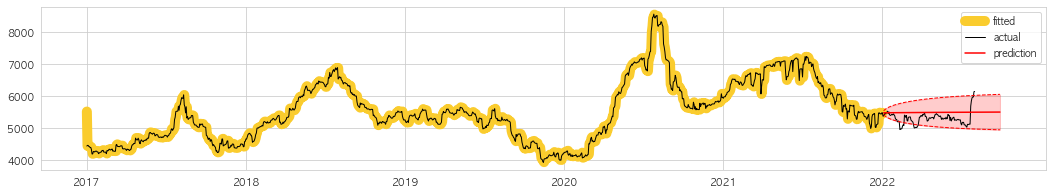

In [30]:
## 고구마 모델 예측 시각화
fig = plt.figure(figsize=(18, 3))
fitted_values = final_model_sp.fittedvalues  ## in-sample prediction
data = df['고구마가격'].values

# prediction
k = 180

forecast = final_model_sp.get_forecast(k)  ## out-of-sample prediction
predicted_values = forecast.predicted_mean
prediction_intervals = forecast.conf_int(alpha=0.5)
upper_limit = [x[1] for x in prediction_intervals]
lower_limit = [x[0] for x in prediction_intervals]

pred_x = range(len(data) + 1, len(data) + k + 1)

# actual 데이터만 2017~2022.08 데이터로 입력
plt.plot(range(len(data)), fitted_values, label='fitted', lw=10, color='#FACC2E')
plt.plot(range(len(df_2022_sp)), df_2022_sp, label='actual', linewidth=1, color='#000000')
plt.plot(pred_x, predicted_values, color='red', label='prediction')
plt.plot(pred_x, lower_limit, color='red', linestyle='--', linewidth=1)
plt.plot(pred_x, upper_limit, color='red', linestyle='--', linewidth=1)
plt.xticks(np.arange(0, 1226, 245),
           labels=[2017, 2018, 2019, 2020, 2021, 2022])
plt.fill_between(pred_x, lower_limit, upper_limit, color='red', alpha=0.2)
plt.legend()

plt.savefig('data/arma03.png')
plt.show()

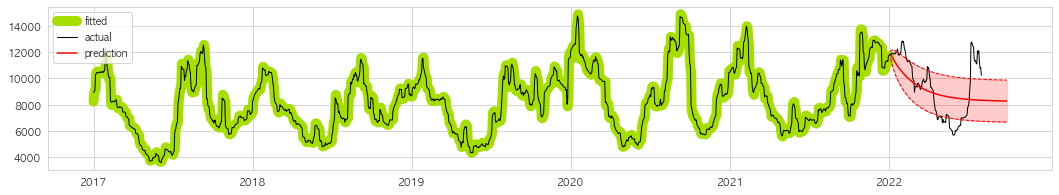

In [29]:
 ## 오이 모델 예측 시각화
fig = plt.figure(figsize=(18, 3))
fitted_values = final_model_ccb.fittedvalues  ## in-sample prediction
data = df['오이가격'].values

# prediction
k = 180

forecast = final_model_ccb.get_forecast(k)  ## out-of-sample prediction
predicted_values = forecast.predicted_mean
prediction_intervals = forecast.conf_int(alpha=0.5)
upper_limit = [x[1] for x in prediction_intervals]
lower_limit = [x[0] for x in prediction_intervals]

pred_x = range(len(data) + 1, len(data) + k + 1)

# actual 데이터만 2017~2022.08 데이터로 입력
plt.plot(range(len(data)), fitted_values, label='fitted', lw=10, color='#A5DF00')
plt.plot(range(len(df_2022_ccb)), df_2022_ccb, label='actual', linewidth=1, color='#000000')
plt.plot(pred_x, predicted_values, color='red', label='prediction')
plt.plot(pred_x, lower_limit, color='red', linestyle='--', linewidth=1)
plt.plot(pred_x, upper_limit, color='red', linestyle='--', linewidth=1)
plt.xticks(np.arange(0, 1226, 245),
           labels=[2017, 2018, 2019, 2020, 2021, 2022])
plt.fill_between(pred_x, lower_limit, upper_limit, color='red', alpha=0.2)
plt.legend()

plt.savefig('data/arma04.png')
plt.show()